##Mount google drive


In [4]:
# from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Kaggle Data download setup

In [ ]:
#from google.colab import files
#files.upload() #upload kaggle.json you just downloaded

In [ ]:
#!pip install -q kaggle
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!ls ~/.kaggle
#!chmod 600 /root/.kaggle/kaggle.json  # set permission
#!pip install wandb
#!pip install wandb --user
#!wandb login
#import wandb
#from wandb.keras import WandbCallback
#!wandb login

*Using Kaggle API failed to download the full dataset to google drive. So I manually downloaded the dataset to my local machine and uploaded to the google drive.*

In [ ]:
# Using Kaggle API had issues downloading the full dataset to google drive. So I manually downloaded the dataset to my local machine and uploaded to the google drive.
#import os
#!rm -rf -f /content/drive/MyDrive/Colab\ Notebooks/data/understanding_cloud_organization
#!mkdir /content/drive/MyDrive/Colab\ Notebooks/data/understanding_cloud_organization
#os.chdir('/content/drive/MyDrive/Colab Notebooks/data/understanding_cloud_organization')
#!kaggle competitions download -c understanding_cloud_organization
#os.chdir('/content/drive/MyDrive/Colab Notebooks/data/understanding_cloud_organization')
#!unzip -o understanding_cloud_organization.zip -d .


In [ ]:
#!pip install keras==2.3.1
#!pip install tensorflow==2.1.0
#!pip install keras_applications==1.0.8
#!pip install image-classifiers==1.0.0
#!pip install efficientnet==1.0.0
#!pip install tensorboardcolab
#!pip install tta-wrapper
#!pip install git+https://github.com/qubvel/tta_wrapper/

import keras
print(keras.__version__)


2.4.3


## Import dependencies

In [ ]:
import pandas as pd
import os
import os.path
from os import path
import numpy as np
from sklearn.model_selection import train_test_split
import random
from keras import optimizers
from keras import backend as K
from keras.utils import Sequence
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization,Input,Conv2DTranspose,Dropout
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate,add
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler,Callback
from keras import Model
from keras.preprocessing import image
from keras.optimizers import RMSprop, SGD, Adam, Nadam
import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import TensorBoard
import tensorflow as tf
import albumentations as albu

print(keras.__version__)

# image size when set to 512 gave oom error in colab, so set to 384
IMG_WIDTH=384
IMG_HEIGHT=384


2.4.3


## Exploratory Data Analysis

Analysing train folders

In [ ]:
path = '/content/drive/MyDrive/Colab_Notebooks/data/understanding_cloud_organization'

train = pd.read_csv(f'{path}/train.csv')

print('Folder struct:')
print(os.listdir(path))
print()
print('Train CSV Column Names:')
print(train.columns)
print()
train.head()

Folder struct:
['sample_submission.csv', 'train.csv', 'understanding_cloud_organization.zip', 'test_images', 'train_images', 'clouds_model_keras_orig.h5', '.ipynb_checkpoints', 'clouds_model_keras.h5', 'clouds_model_keras_transfer.h5']

Train CSV Column Names:
Index(['Image_Label', 'EncodedPixels'], dtype='object')



Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

All images can have up to 4 types of clouds.

2    2372
3    1560
1    1348
4     266
Name: Image_Label, dtype: int64



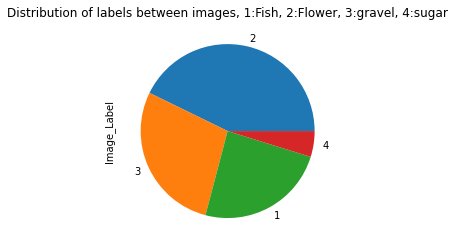

In [ ]:
# Create pie chart of cloud label ditributions
non_empty_rows = train.loc[train['EncodedPixels'].isnull()==False, 'Image_Label']
non_empty_labels = non_empty_rows.apply(lambda x:x.split('_')[0])
non_empty_labels_count=non_empty_labels.value_counts()
non_empty_labels_count_per_label= non_empty_labels_count.value_counts()
print(non_empty_labels_count_per_label)
print()
ax=non_empty_labels_count_per_label.plot(kind='pie')
ax.set_title("Distribution of labels between images, 1:Fish, 2:Flower, 3:gravel, 4:sugar")
plt.show()

## Preprocess Data


In [ ]:
# Preprocess data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])

# Create one column for each mask
train = train.fillna('')
train_df = pd.pivot_table(train, index=['image'], values=['EncodedPixels'], columns=['label'], aggfunc=np.sum).astype(str)
train_df = train_df.reset_index()
train_df.columns = ['image_id', 'Fish_mask', 'Flower_mask', 'Gravel_mask', 'Sugar_mask']

print('Total Images:', len(train_df))
display(train.head())
print()
display(train_df.head())

# Verify pivot worked as expected
print(train_df.Flower_mask[0])
print()
print(train.EncodedPixels[1])

Total Images: 5546


Image_Label  ...   label
0    0011165.jpg_Fish  ...    Fish
1  0011165.jpg_Flower  ...  Flower
2  0011165.jpg_Gravel  ...  Gravel
3   0011165.jpg_Sugar  ...   Sugar
4    002be4f.jpg_Fish  ...    Fish

[5 rows x 4 columns]

image_id  ...                                         Sugar_mask
0  0011165.jpg  ...                                                   
1  002be4f.jpg  ...  67495 350 68895 350 70295 350 71695 350 73095 ...
2  0031ae9.jpg  ...  658170 388 659570 388 660970 388 662370 388 66...
3  0035239.jpg  ...                                                   
4  003994e.jpg  ...  28011 489 29411 489 30811 489 32211 489 33611 ...

[5 rows x 5 columns]

1355565 1002 1356965 1002 1358365 1002 1359765 1002 1361165 1002 1362565 1002 1363965 1002 1365365 1002 1366765 1002 1368165 1002 1369565 1002 1370965 1002 1372365 1002 1373765 1002 1375165 1002 1376565 1002 1377965 1002 1379365 1002 1380765 1002 1382165 1002 1383565 1002 1384965 1002 1386365 1002 1387765 1002 1389165 1002 1390565 1002 1391965 1002 1393365 1002 1394765 1002 1396165 1002 1397565 1002 1398965 1002 1400365 1002 1401765 1002 1403165 1002 1404565 1002 1405965 1002 1407365 1002 1408765 1002 1410165 1002 1411565 1002 1412965 1002 1414365 1002 1415765 1002 1417165 1002 1418565 1002 1419965 1002 1421365 1002 1422765 1002 1424165 1002 1425565 1002 1426965 1002 1428365 1002 1429765 1002 1431165 1002 1432565 1002 1433965 1002 1435365 1002 1436765 1002 1438165 1002 1439565 1002 1440965 1002 1442365 121 1442487 880 1443765 1002 1445165 1002 1446565 1002 1447965 1002 1449365 1002 1450765 1002 1452165 1002 1453565 1002 1454965 1002 1456365 1002 1457765 1002 1459165 1002 1460565 1002 1

In [ ]:
# Verify by writting to file
train_df.to_csv("train_df_pivot.csv", index=False)

In [ ]:
dataset = pd.read_csv("train_df_pivot.csv")
dataset.head()

image_id  ...                                         Sugar_mask
0  0011165.jpg  ...                                                NaN
1  002be4f.jpg  ...  67495 350 68895 350 70295 350 71695 350 73095 ...
2  0031ae9.jpg  ...  658170 388 659570 388 660970 388 662370 388 66...
3  0035239.jpg  ...                                                NaN
4  003994e.jpg  ...  28011 489 29411 489 30811 489 32211 489 33611 ...

[5 rows x 5 columns]

In [ ]:
# Replace NaN's with empty strings
dataset.fillna('', inplace=True)
dataset.head()

image_id  ...                                         Sugar_mask
0  0011165.jpg  ...                                                   
1  002be4f.jpg  ...  67495 350 68895 350 70295 350 71695 350 73095 ...
2  0031ae9.jpg  ...  658170 388 659570 388 660970 388 662370 388 66...
3  0035239.jpg  ...                                                   
4  003994e.jpg  ...  28011 489 29411 489 30811 489 32211 489 33611 ...

[5 rows x 5 columns]

## Train Test split

In [ ]:
train_data, cv_data = train_test_split(dataset, test_size=0.15, random_state=42)
print("Train data size", train_data.shape)
print("Test data size", cv_data.shape)

Train data size (4714, 5)
Test data size (832, 5)


## Create Data generators

In [ ]:
train_base_path = '/content/drive/MyDrive/Colab_Notebooks/data/understanding_cloud_organization/train_images/'
def get_cloud_type(index):
    if index==1:
      return 'Fish_mask'
    elif index==2:
      return 'Flower_mask'
    elif index==3:
      return 'Gravel_mask'
    elif index==4:
      return 'Sugar_mask'
    else:
      return 'unknown'

# Create custom data generator for train data
# ref: https://medium.com/swlh/a-detailed-explanation-of-custom-datagenerators-in-keras-b978cdd0ca17
class Train_DataGenerator(keras.utils.Sequence):
    def __init__(self, train_df, batch_size = 32,shuffle=False, mode='fit', 
                 augmentation=None, info={}):
      super().__init__()
      self.data = train_df
      self.shuffle = shuffle
      self.batch_size = batch_size
      self.info = info
      self.directory = train_base_path
      self.on_epoch_end()
      self.mode=mode
      self.augmentation=augmentation

    def __len__(self):
      return int(np.floor(len(self.data) / self.batch_size))

    # actions to be taken at end of each epoch
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __getitem__(self, index):
        train_datagen = image.ImageDataGenerator()
        # standardize image pixels
        param = {'samplewise_std_normalization' : True}
        
        # Creates an empty placeholder array that will be populated with data that is to be supplied
        #images
        X = np.empty((self.batch_size,IMG_HEIGHT,IMG_WIDTH,3),dtype=np.float32) # not specifying type gives error
        #masks
        y = np.empty((self.batch_size,IMG_HEIGHT,IMG_WIDTH,4),dtype=np.float32)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f_name in enumerate(self.data['image_id'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f_name
            # ref:  https://keras.io/api/preprocessing/image/
            img = image.load_img(self.directory + f_name).resize((IMG_WIDTH,IMG_HEIGHT))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
            # convert run-length encoding on the pixel values to masks
            for j in range(4):
                mask = conv_rle_to_mask(self.data[get_cloud_type(j+1)].iloc[indexes[i]])
                mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
                y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)

        if self.mode=='fit':
            if self.augmentation:
                X, Y = self._augment_batch(X, y)
        return X, y

    def _augment_batch(self, X_batch, y_batch):
        for i in range(X_batch.shape[0]):
            X_batch[i, ], y_batch[i, ] = self._apply_transform_randomly(X_batch[i, ], y_batch[i, ])
        return X_batch, y_batch
    
    def _apply_transform_randomly(self, X_aug, y_aug):
        # ref: https://albumentations.ai/docs/getting_started/mask_augmentation/
        augmented = self.augmentation(image=X_aug, mask=y_aug)
        X_aug = augmented['image']
        y_aug = augmented['mask']
        
        return X_aug, y_aug



In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
class Val_DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 32, shuffle=False, augmentation=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.info = info
        self.directory = train_base_path
        self.on_epoch_end()
        self.augmentation=augmentation
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'samplewise_std_normalization' : True}
        
        X = np.empty((self.batch_size,IMG_HEIGHT,IMG_WIDTH,3),dtype=np.float32)
        y = np.empty((self.batch_size,IMG_HEIGHT,IMG_WIDTH,4),dtype=np.float32)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f_name in enumerate(self.df['image_id'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f_name
            img = image.load_img(self.directory + f_name).resize((IMG_WIDTH,IMG_HEIGHT))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
            # convert run-length encoding on the pixel values to masks
            for j in range(4):
                mask = conv_rle_to_mask(self.df[get_cloud_type(j+1)].iloc[indexes[i]])
                mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
                y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)

        if self.augmentation:
            X, Y = self._augment_batch(X, y)
        return X, y

    def _augment_batch(self, X_batch, y_batch):
        for i in range(X_batch.shape[0]):
            X_batch[i, ], y_batch[i, ] = self._apply_transform_randomly(X_batch[i, ], y_batch[i, ])
        return X_batch, y_batch
    
    def _apply_transform_randomly(self, X_aug, y_aug):
        # ref: https://albumentations.ai/docs/getting_started/mask_augmentation/
        augmented = self.augmentation(image=X_aug, mask=y_aug)
        X_aug = augmented['image']
        y_aug = augmented['mask']
        return X_aug, y_aug

## Utility functions for masks

In [ ]:
def conv_rle_to_mask(rle):
    height= 1400
    width = 2100
    # return a mask of zeros for empty rle 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((height,width) ,dtype=np.uint8)
    
    # create full size mask, resize in data generator
    height= 1400
    width = 2100
    mask= np.zeros( width*height ,dtype=np.uint8)
    # create array of start and length pixels
    array = np.asarray([int(x) for x in rle.split()])
    # first element of each pair are start pixels
    starts = array[0::2]-1
    # second element of each pair is length pixel
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        # set 1 to all pixels of rle
        mask[int(start):int(start+lengths[index])] = 1
    
    # The pixels are numbered from top to bottom, then left to right: 1 is pixel , 2 is pixel , etc.
    return mask.reshape( (height,width), order='F' )


# Inverse function to validate functionality
def conv_mask_to_rle(img):
    # convert 3 dim array to 1 dimensional
    pixels= img.T.flatten() 
    # add zeros as buffer pixels for start and end masks
    pixels = np.concatenate([[0], pixels, [0]])
    # Get all pixels which change from 0 to 1 or 1 to 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1 
    # Store length pixels at odd positions. Lengths = odd indices - even indices
    runs[1::2] -= runs[::2] 
    # create rle string
    return ' '.join(str(x) for x in runs)

Cloud Type:  Fish_mask
image 9ab5137.jpg
image c32bfd6.jpg
image add4875.jpg


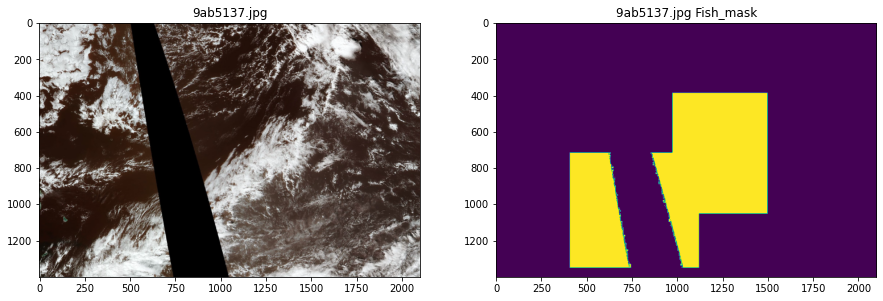

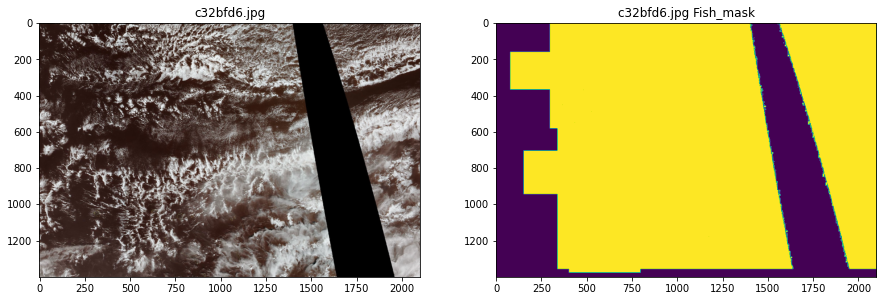

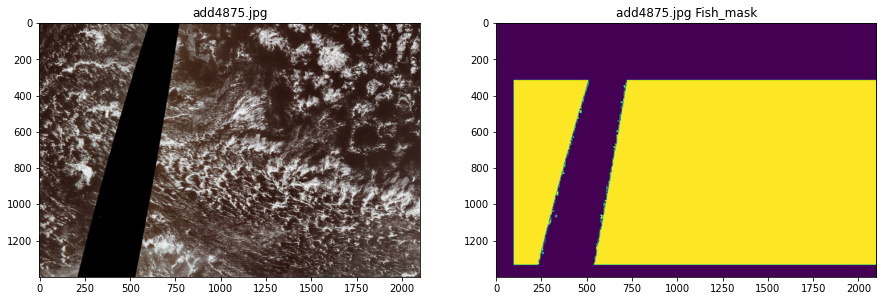

----------------------------------------------------------------------
Cloud Type:  Flower_mask
image 33b39e2.jpg
image 1930ced.jpg
image add4875.jpg


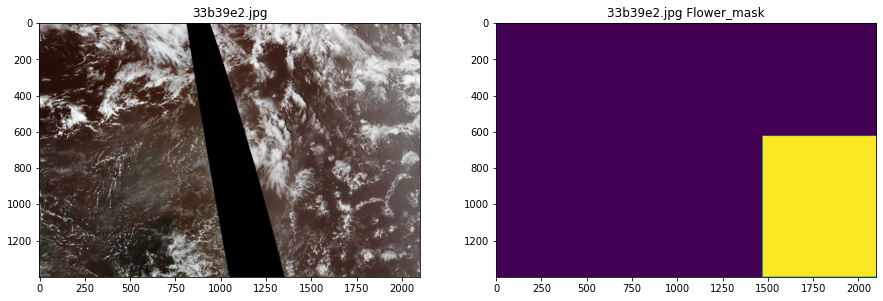

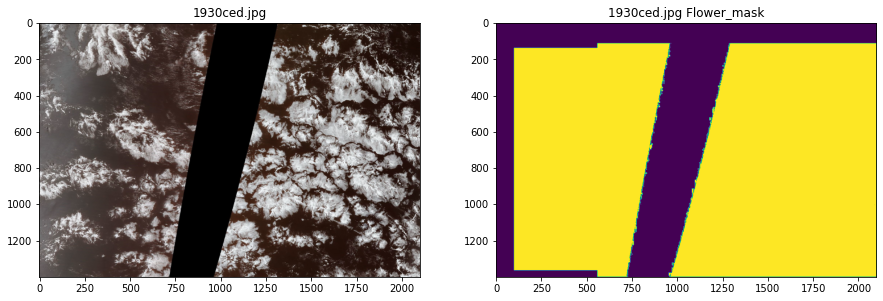

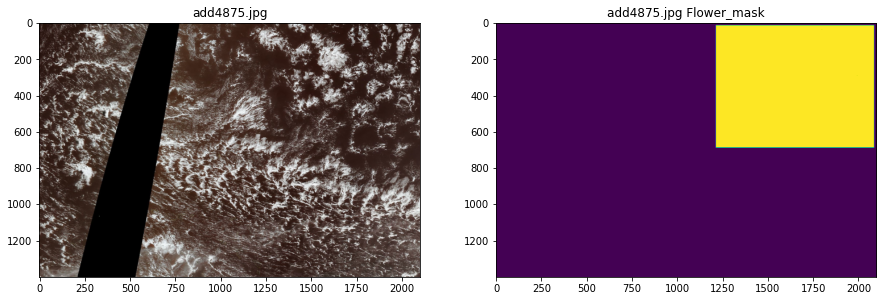

----------------------------------------------------------------------
Cloud Type:  Gravel_mask
image 33b39e2.jpg
image 9ab5137.jpg
image 8644e6e.jpg


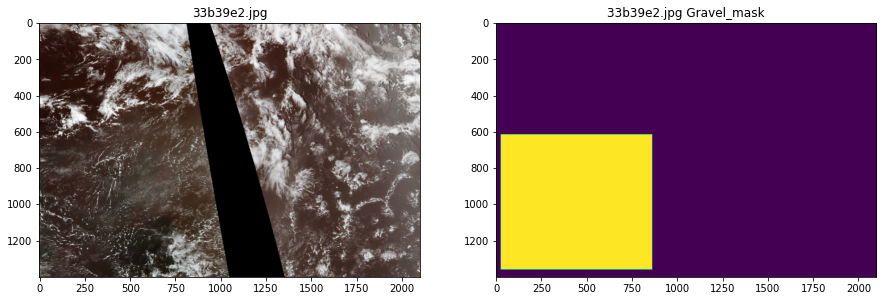

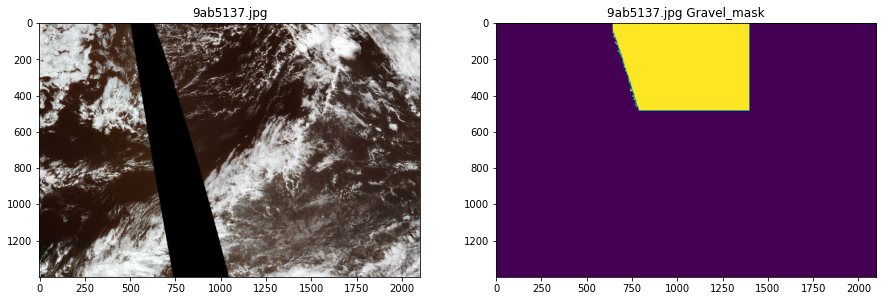

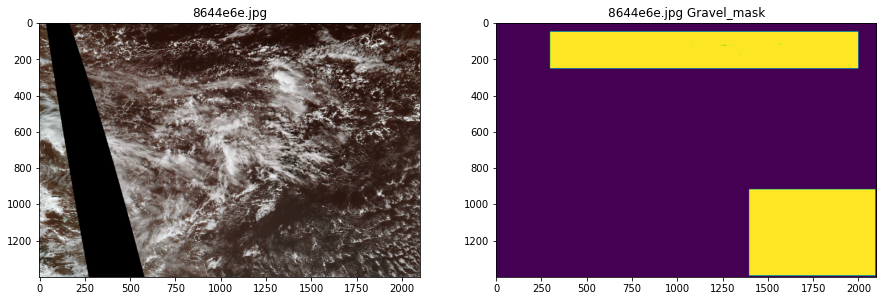

----------------------------------------------------------------------
Cloud Type:  Sugar_mask
image 33b39e2.jpg
image 9ab5137.jpg
image 4701545.jpg


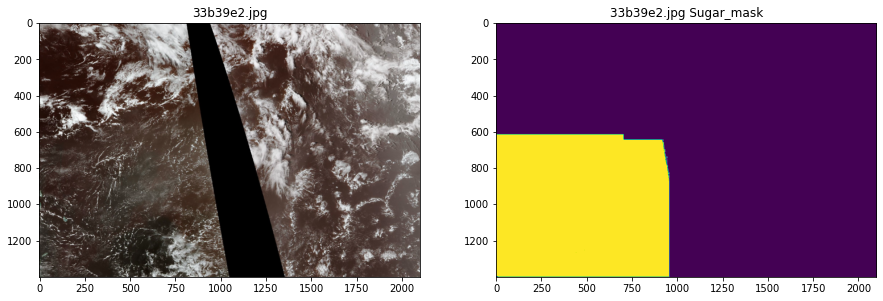

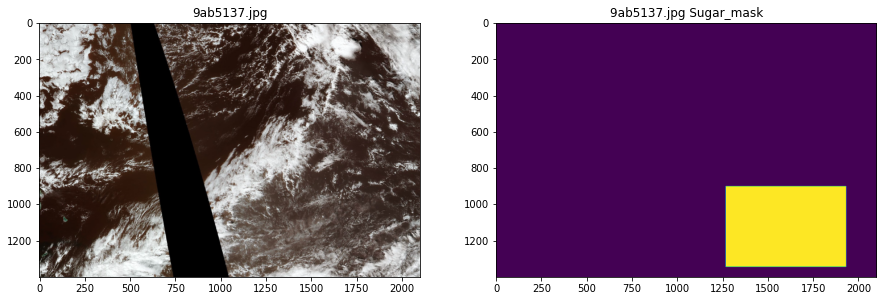

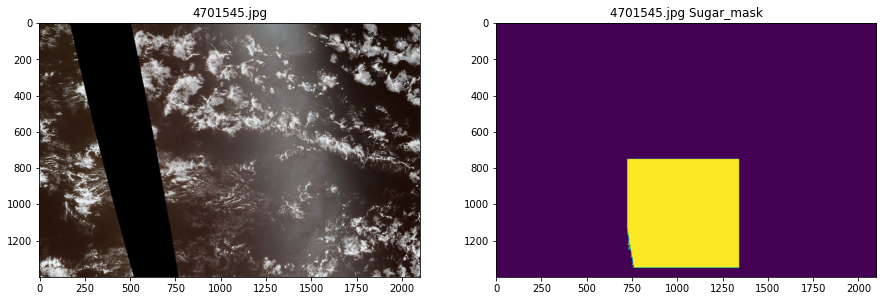

----------------------------------------------------------------------


In [ ]:
# Visualse masks
for k in [1,2,3,4]:
    mt=0
    print("Cloud Type: ",  get_cloud_type(k))
    ct=get_cloud_type(k)
    for i in train_data[train_data[get_cloud_type(k)]!=''][['image_id',get_cloud_type(k)]].values:
        if mt > 2:
          continue
        fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 15))
        img = cv2.imread(train_base_path + str(i[0]))
        print('image', str(i[0]))
        ax1.set_title(i[0])
        ax1.imshow(img)
        ax2.set_title(i[0]+' '+str(get_cloud_type(k)))
        ax2.imshow(conv_rle_to_mask(i[1]))
        mt+=1
    plt.show()
    print('----------------------------------------------------------------------')

## Evaluate Mask functions

In [ ]:
conv_mask_to_rle(conv_rle_to_mask(i[1]))

'1708355 61 1708421 3 1708425 1 1708429 3 1708433 8 1709755 52 1709809 1 1709815 2 1709825 1 1709829 3 1709833 8 1711155 49 1711206 3 1711212 9 1711229 12 1712555 45 1712601 1 1712603 5 1712609 1 1712620 1 1712624 1 1712629 12 1713955 40 1713996 1 1713999 8 1715355 37 1715393 1 1715396 4 1715401 4 1715406 3 1716755 38 1716795 5 1716805 4 1718155 37 1718195 2 1718199 1 1718201 8 1719555 31 1719591 5 1719599 2 1720955 27 1720984 1 1720987 3 1720992 1 1720997 4 1722355 35 1722396 5 1722412 5 1723755 26 1723782 4 1723789 6 1723796 5 1723810 2 1725155 46 1726555 46 1727955 22 1727985 16 1729355 14 1729393 8 1730755 8 1730767 2 1732156 2 1732159 1 1732161 2 1732164 1 1732167 2 1733555 3 1733559 2 1733564 2 1734955 1 1734957 2 1734961 1 1734964 1 1734967 1 1736355 1 1737759 2 1739155 6 1740555 6 1848921 4 1850321 4 1851721 4 1853121 4 1854521 4 1855921 4 1857321 4 1858721 4 1860100 3 1860107 1 1860113 1 1860116 1 1860120 1 1860122 1 1861512 1 1861516 9 1862871 2 1862905 5 1862914 2 1862918 3 

In [ ]:
i[1]

'1708355 61 1708421 3 1708425 1 1708429 3 1708433 8 1709755 52 1709809 1 1709815 2 1709825 1 1709829 3 1709833 8 1711155 49 1711206 3 1711212 9 1711229 12 1712555 45 1712601 1 1712603 5 1712609 1 1712620 1 1712624 1 1712629 12 1713955 40 1713996 1 1713999 8 1715355 37 1715393 1 1715396 4 1715401 4 1715406 3 1716755 38 1716795 5 1716805 4 1718155 37 1718195 2 1718199 1 1718201 8 1719555 31 1719591 5 1719599 2 1720955 27 1720984 1 1720987 3 1720992 1 1720997 4 1722355 35 1722396 5 1722412 5 1723755 26 1723782 4 1723789 6 1723796 5 1723810 2 1725155 46 1726555 46 1727955 22 1727985 16 1729355 14 1729393 8 1730755 8 1730767 2 1732156 2 1732159 1 1732161 2 1732164 1 1732167 2 1733555 3 1733559 2 1733564 2 1734955 1 1734957 2 1734961 1 1734964 1 1734967 1 1736355 1 1737759 2 1739155 6 1740555 6 1848921 4 1850321 4 1851721 4 1853121 4 1854521 4 1855921 4 1857321 4 1858721 4 1860100 3 1860107 1 1860113 1 1860116 1 1860120 1 1860122 1 1861512 1 1861516 9 1862871 2 1862905 5 1862914 2 1862918 3 

## Create loss functions

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy
# Add smoothing factor to prevent 'gradient exploding'
def dice_coef(y_gt, y_pred, smooth=1):
    y_gt_flat = K.flatten(y_gt)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_gt_flat * y_pred_flat)
    return (2. * intersection + smooth) / (K.sum(y_gt_flat) + K.sum(y_pred_flat) + smooth)
  
def bce_dice_loss(y_gt, y_pred):
    return binary_crossentropy(y_gt, y_pred) + (1-dice_coef(y_gt, y_pred))

def dice_loss(y_gt, y_pred):
    return (1-dice_coef(y_gt, y_pred))

def jaccard_distance(y_gt, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_gt * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_gt) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

## Create U-Net NN

In [ ]:
def repeat_conv_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # Does 2x Conv2d + Batch norm + Relu
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm == True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
# ref: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
def build_unet(input_img, n_filters, dropout, batchnorm):
    # Contracting Network
    #U1
    conv1 = repeat_conv_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)
    
    #U2
    conv2 = repeat_conv_block(pool1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)
    
    #U3
    conv3 = repeat_conv_block(pool2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)
    
    #U4
    conv4 = repeat_conv_block(pool3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)
    
    conv5 = repeat_conv_block(pool4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expanding Network
    #U4
    ups6 = UpSampling2D()(conv5)
    #Trying to use padding=’valid’ gave error about dimensions not matching, so had to use padding=’same’
    ups6 = Conv2D(filters = n_filters *8, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(ups6)
    ups6 = concatenate([ups6, conv4])
    ups6 = Dropout(dropout)(ups6)
    conv6 = repeat_conv_block(ups6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    #U3
    ups7 = UpSampling2D()(conv6)
    ups7 = Conv2D(filters = n_filters *4, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(ups7)
    ups7 = concatenate([ups7, conv3])
    ups7 = Dropout(dropout)(ups7)
    conv7 = repeat_conv_block(ups7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    #U2
    ups8 = UpSampling2D()(conv7)
    ups8 = Conv2D(filters = n_filters *2, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(ups8)
    ups8 = concatenate([ups8, conv2])
    ups8 = Dropout(dropout)(ups8)
    conv8 = repeat_conv_block(ups8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    #U1
    ups9 = UpSampling2D()(conv8)
    ups9 = Conv2D(filters = n_filters *1, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(ups9)
    ups9 = concatenate([ups9, conv1])
    ups9 = Dropout(dropout)(ups9)
    conv9 = repeat_conv_block(ups9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    output_tensor = Conv2D(4, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[input_img], outputs=[output_tensor])
    return model

In [ ]:
def build_model_func():
  input_img = Input((IMG_HEIGHT, IMG_WIDTH, 3), name='img')
  model = build_unet(input_img, n_filters=8, dropout=0.2, batchnorm=True)
  model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
  #model.compile(optimizer=Nadam(lr=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
  model.summary()
  from keras.utils import plot_model
  plot_model(model, show_shapes=True)
  return model

## Save model

In [ ]:
#from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
ES_PATIENCE=10
RLROP_PATIENCE=10
#tbc=TensorBoardColab()
checkpoints = ModelCheckpoint(path + '/clouds_model_keras.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_dice_coef', mode='max', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
#rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
callbacks_list = [checkpoints]

## Hyperparameter tuning using wandb

In [ ]:
sweep_config = {
      'method': 'random', #grid, random
      'metric': {
        'name': 'val_dice_coef',
        'goal': 'maximize'   
      },
      'parameters': {
          'epochs': {
              'values': [20, 32, 50, 75]
          },
          'batch_size': {
              'values': [256, 128, 64, 32]
          },
          'dropout': {
              'values': [0.0, 0.2, 0.3, 0.4, 0.5]
          },
          'conv_layer_size': {
              'values': [8, 16]
          },
          'learning_rate': {
              'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
          },
          'optimizer': {
              'values': ['adam', 'nadam', 'sgd', 'rmsprop']
          }
      }
  }


In [ ]:
def train():
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
  
  config_defaults = {
      'epochs': 50,
      'batch_size': 32,
      'dropout': 0.2,
      'conv_layer_size': 8,
      'learning_rate': 1e-3,
      'optimizer': 'adam',
      'momentum': 0.9,
  }
  # Initialize a new wandb run
  wandb.init(config=config_defaults)

  # Config is a variable that holds and saves hyperparameters and inputs
  config = wandb.config
  
    # Define the optimizer
  if config.optimizer=='sgd':
    optimizer = SGD(lr=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
  elif config.optimizer=='rmsprop':
    optimizer = RMSprop(lr=config.learning_rate, decay=1e-5)
  elif config.optimizer=='adam':
    optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
  elif config.optimizer=='nadam':
    optimizer = Nadam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

  input_img = Input((IMG_HEIGHT, IMG_WIDTH, 3), name='img')
  model = get_unet(input_img, n_filters=config.conv_layer_size, dropout=config.dropout, batchnorm=True)
  model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_coef])
  model.summary()
  train_batches = Train_DataGenerator(train_data,shuffle=True, batch_size=config.batch_size)
  valid_batches = Val_DataGenerator(cv_data, batch_size=config.batch_size, path=train_base_path)
  model.fit_generator(train_batches,
          epochs=config.epochs,
          validation_data=valid_batches,
          callbacks=[WandbCallback(),
                      EarlyStopping(patience=10, restore_best_weights=True)])

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
#sweep_id = wandb.sweep(sweep_config, entity="jam244", project="cloud")
#wandb.agent(sweep_id, train)

*Due to 12 hour cut out limit on Colab hyperparam tunning was moved to Hex: Nitt.* 
*Progress can be visualized here:* https://wandb.ai/jam244/cloud/sweeps

## Data Augmentation

In [ ]:
augmentation_def = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.RandomRotate90(p=0.5),
                             albu.Transpose(p=0.5),
                             albu.GridDistortion(p=0.5),
                             albu.OpticalDistortion(p=0.5),
                             albu.ElasticTransform(p=0.5,alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                             albu.RandomSizedCrop(min_max_height=(50, 101), height=IMG_HEIGHT, width=IMG_WIDTH, p=0.5),
                             albu.RandomBrightnessContrast(p=0.5),    
                             albu.RandomGamma(p=0.5)
                            ])

augmentation = albu.Compose([albu.HorizontalFlip(p=0.2),
                             albu.VerticalFlip(p=0.2),
                             albu.RandomSizedCrop(min_max_height=(50, 101), height=IMG_HEIGHT, width=IMG_WIDTH, p=0.2),
                             albu.ElasticTransform(p=0.2,alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
                            ])

augmentation_val = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5)
                            ])


random.seed(11)

In [ ]:
train_batches = Train_DataGenerator(train_data,mode='fit', batch_size=32, augmentation=augmentation, shuffle=True)
valid_batches = Val_DataGenerator(cv_data, batch_size=32)


## Re-Train NN with best Hyperparameters

In [ ]:
from keras.models import load_model
dependencies = {'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef}

# Load checkpoint:
#checkpoint_path = path + '/clouds_model_keras.h5'
#if os.path.isfile(checkpoint_path):
    # Load model:
#    model = load_model(checkpoint_path, custom_objects=dependencies)
    # Finding the epoch index from which we are resuming
    #initial_epoch = get_init_epoch(checkpoint_path)
#else:
model = build_model_func()
initial_epoch = 0

# Start/resume training

history = model.fit_generator(train_batches, validation_data = valid_batches, 
                              epochs = 50, verbose=1, callbacks = callbacks_list)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 384, 384, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 384, 384, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
147/147 [==============================] - 5868s 40s/step - loss: 1.4311 - dice_coef: 0.2370 - val_loss: 5.3035 - val_dice_coef: 0.2411

Epoch 00001: val_dice_coef improved from -inf to 0.24106, saving model to /content/drive/MyDrive/Colab_Notebooks/data/understanding_cloud_organization/clouds_model_keras.h5
Epoch 2/50
147/147 [==============================] - 552s 4s/step - loss: 1.2508 - dice_coef: 0.2472 - val_loss: 1.3573 - val_dice_coef: 0.3209

Epoch 00002: val_dice_coef improved from 0.24106 to 0.32090, saving model to /content/drive/MyDrive/Colab_Notebooks/data/understanding_cloud_organization/clouds_model_keras.h5
Epoch 3/50
147/147 [==============================] - 545s 4s/step - loss: 1.1113 - dice_coef: 0.2985 - val_loss: 1.1449 - val_dice_coef: 0.3665

Epoch 00003: val_dice_coef improved from 0.32090 to 0.36650, saving model to /content/drive/MyDrive/Colab_Notebooks/data/understanding_cloud_organization/clouds_model_keras.h5
Epoch 4/50
147/147 [===============

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])


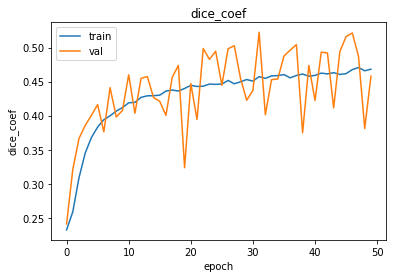

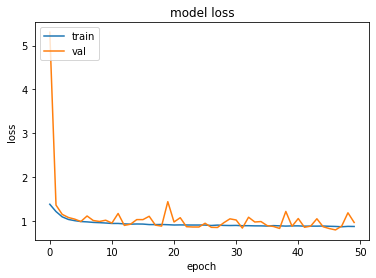

In [ ]:
print(history.history.keys())
# summarize history for dice_coef
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate Model

###  Evaluate with validation data

In [ ]:
from keras.models import load_model

valid_batches = Val_DataGenerator(cv_data)

dependencies = {'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef}

model = load_model(path+'/clouds_model_keras.h5', custom_objects=dependencies)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
evals= model.evaluate(valid_batches,verbose=1)

26/26 [==============================] - 1128s 44s/step - loss: 0.8389 - dice_coef: 0.5207


In [ ]:
print('Validation score:')
print('loss:',evals[0])
print('dice_coeff:',evals[1])

Validation score:
loss: 0.8318309187889099
dice_coeff: 0.5224238634109497


### Evaluate with augmented validation data

In [ ]:
valid_batches = Val_DataGenerator(cv_data, augmentation=augmentation_val)

dependencies = {'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef}

model = load_model(path+'/clouds_model_keras.h5', custom_objects=dependencies)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
evals= model.evaluate(valid_batches,verbose=1)

26/26 [==============================] - 71s 3s/step - loss: 0.8439 - dice_coef: 0.5176


In [ ]:
print('Validation with augmentation score:')
print('loss:',evals[0])
print('dice_coeff:',evals[1])

Validation with augmentation score:
loss: 0.8365769982337952
dice_coeff: 0.5198521018028259


## Post process

In [ ]:
def post_process(probability, threshold_val, mask_size):
  # seperate cloud from background
  # returns tuple consisting of threshold value and modified image array
  prob_thres=cv2.threshold(probability, thresh=threshold_val, maxval=1, type=cv2.THRESH_BINARY)[1]
  # get connected components
  num_components, components = cv2.connectedComponents(prob_thres.astype(np.uint8))
  thr_pred = np.zeros(probability.shape, np.float32)
  # Connected Component Labeling
  for label_id in range(1, num_components):
      comp = (components == label_id)
      if comp.sum() > mask_size:
          thr_pred[comp] = 1
  return thr_pred



In [ ]:
label_names = ['Fish', 'Flower', 'Gravel', 'Sugar']
thresholds=[.5, .5, .5, .35]
mask_size=[25000, 20000, 22500, 15000]


In [ ]:
def apply_post_process(model, data_frame, thresholds, mask_size, set_name):
  # apply post_process in batches
  metrics = []
  print('data frame size', data_frame.shape[0])
  print('using thresholds', thresholds)
  print('using mask_size', mask_size)

  if set_name=='train':
    print('------Predicting train--------')
  else:
    print('------Predicting Validation----')
  for label_name in label_names:
      metrics.append([label_name, 0, 0])

  metrics_df = pd.DataFrame(metrics, columns=['Label', 'Dice', 'Dice Post'])
    
  for i in range(0, data_frame.shape[0], 300):
      batch_idx = list(range(i, min(data_frame.shape[0], i + 300)))
      batch_set = data_frame[batch_idx[0]: batch_idx[-1]+1]
      print(len(batch_set))
      ratio = len(batch_set) / len(data_frame)
      if set_name=='train':
          generator=Train_DataGenerator(batch_set, shuffle=True, mode='pred', batch_size=len(batch_set))
      else:
          generator=Val_DataGenerator(batch_set, shuffle=True, batch_size=len(batch_set))
      x, y = generator.__getitem__(0)
      preds = model.predict(x)
      for class_index in range(len(label_names)):
          class_score = []
          class_score_post = []
          mask_class = y[..., class_index]
          pred_class = preds[..., class_index]
          for index in range(len(batch_idx)):
              sample_mask = mask_class[index, ]
              sample_pred = pred_class[index, ]
              sample_pred_post = post_process(sample_pred, threshold_val=thresholds[class_index], mask_size=mask_size[class_index])
              if (sample_mask.sum() == 0) & (sample_pred.sum() == 0):
                  dice_score = 1.
              else:
                  dice_score = dice_coef(sample_pred, sample_mask)
              if (sample_mask.sum() == 0) & (sample_pred_post.sum() == 0):
                  dice_score_post = 1.
              else:
                  dice_score_post = dice_coef(sample_pred_post, sample_mask)
              class_score.append(dice_score)
              class_score_post.append(dice_score_post)
          metrics_df.loc[metrics_df['Label'] == label_names[class_index], 'Dice'] += np.mean(class_score) * ratio
          metrics_df.loc[metrics_df['Label'] == label_names[class_index], 'Dice Post'] += np.mean(class_score_post) * ratio

  metrics_df = metrics_df.append({'Label':set_name, 'Dice':np.mean(metrics_df['Dice'].values), 'Dice Post':np.mean(metrics_df['Dice Post'].values)}, ignore_index=True).set_index('Label')
  del generator
  mean_dice_post=np.mean(metrics_df['Dice Post'].values)
  return metrics_df, mean_dice_post


### Hyperparameter tuning for post processing

In [ ]:
import random
#val_pp, mean_dice_post = apply_post_process(model, cv_data, thresholds, mask_size, set_name='val')
#display(val_pp)

#train_pp = apply_post_process(model, train_data, thresholds, mask_size, set_name='train')
#display(train_pp)
#print('val mean dice post', mean_dice_post)
best_threshold=0.0
best_mask_size=0
mask_size_range=np.arange(5000, 30000, 5000)
threshold_range=np.arange(0.1, 1.0, 0.05, dtype=np.float32)
print(mask_size_range)
print(threshold_range)
best_mean_dice_post=0.0
for th in range(50):
    ths=random.choices(threshold_range, k=4)
    ms= random.choices(mask_size_range, k=4)
    val_pp, mean_dice_post = apply_post_process(model, cv_data, ths, ms, set_name='val')
    if mean_dice_post > best_mean_dice_post:
        best_mean_dice_post=mean_dice_post
        best_mask_size= ms
        best_threshold=ths

print("best_mask_size", best_mask_size)
print('best_threshold', best_threshold)
print('best_mean_dice_post', best_mean_dice_post)

[ 5000 10000 15000 20000 25000]
[0.1        0.15       0.20000002 0.25       0.3        0.35000002
 0.4        0.45000002 0.50000006 0.5500001  0.6000001  0.6500001
 0.70000005 0.75000006 0.8000001  0.8500001  0.9000001  0.9500001 ]
data frame size 832
using thresholds [0.45000002, 0.20000002, 0.25, 0.8500001]
using mask_size [5000, 5000, 5000, 25000]
------Predicting Validation----
300
300
232
data frame size 832
using thresholds [0.15, 0.8500001, 0.45000002, 0.15]
using mask_size [5000, 10000, 20000, 25000]
------Predicting Validation----
300
300
232
data frame size 832
using thresholds [0.3, 0.3, 0.15, 0.4]
using mask_size [10000, 25000, 25000, 10000]
------Predicting Validation----
300
300
232
data frame size 832
using thresholds [0.45000002, 0.5500001, 0.15, 0.9000001]
using mask_size [5000, 20000, 5000, 15000]
------Predicting Validation----
300
300
232
data frame size 832
using thresholds [0.9500001, 0.20000002, 0.45000002, 0.50000006]
using mask_size [5000, 5000, 10000, 20000]


In [ ]:
#best_threshold=[.45, .70, .45, .30]
#best_mask_size=[20000, 10000, 10000, 5000]
val_pp, mean_dice_post = apply_post_process(model, cv_data, best_threshold, best_mask_size , set_name='val')
display(val_pp)


data frame size 832
using thresholds [0.5500001, 0.8500001, 0.20000002, 0.75000006]
using mask_size [15000, 10000, 25000, 20000]
------Predicting Validation----
300
300
232


Dice  Dice Post
Label                      
Fish    0.219646   0.577953
Flower  0.257096   0.719549
Gravel  0.239615   0.580564
Sugar   0.386572   0.539648
val     0.275732   0.604429

## Visualize Predictions

In [ ]:
def visualize_val_predictions(image, mask, predicted_mask, post_process_mask):
    """
    Plot image ,original mask, predicted mask and post processed masks.
    """
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))


    ax[0, 0].imshow(image)
    ax[0, 0].set_title("Original image", fontsize=fontsize)
    ax[0, 0].axis('off')

    for i in range(4):
        ax[0, i + 1].imshow(mask[:, :, i])
        ax[0, i + 1].set_title(f"Original mask {class_dict[i]}", fontsize=fontsize)
        ax[0, i + 1].axis('off')

    ax[1, 0].imshow(image)
    ax[1, 0].set_title("Original image", fontsize=fontsize)
    ax[1, 0].axis('off')

    for i in range(4):
        ax[1, i + 1].imshow(predicted_mask[:, :, i])
        ax[1, i + 1].set_title(f"Predicted mask {class_dict[i]}", fontsize=fontsize)
        ax[1, i + 1].axis('off')

    ax[2, 0].imshow(image)
    ax[2, 0].set_title("Transformed image", fontsize=fontsize)
    ax[2, 0].axis('off')

    for i in range(4):
        ax[2, i + 1].imshow(post_process_mask[:, :, i])
        ax[2, i + 1].set_title(
            f"Predicted mask with Post processing {class_dict[i]}", fontsize=fontsize
        )
        ax[2, i + 1].axis('off')
    plt.tight_layout()



## Visualize predictions for Validation dataset

['444ac39.jpg' 'f2cac27.jpg' 'be7940e.jpg']
(3, 5)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(3, 384, 384, 4)


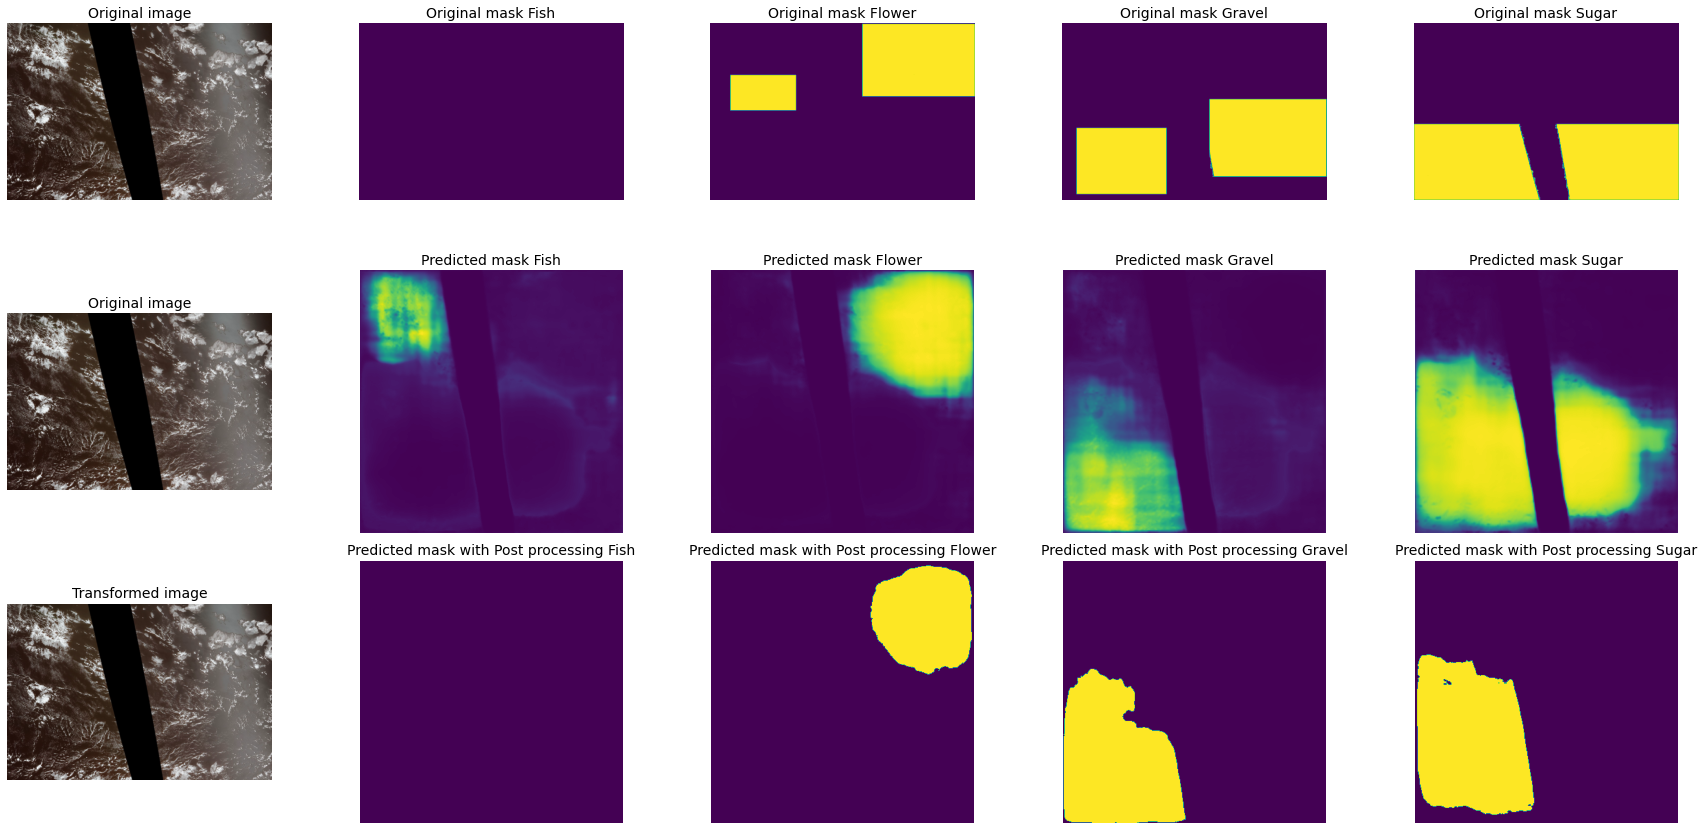

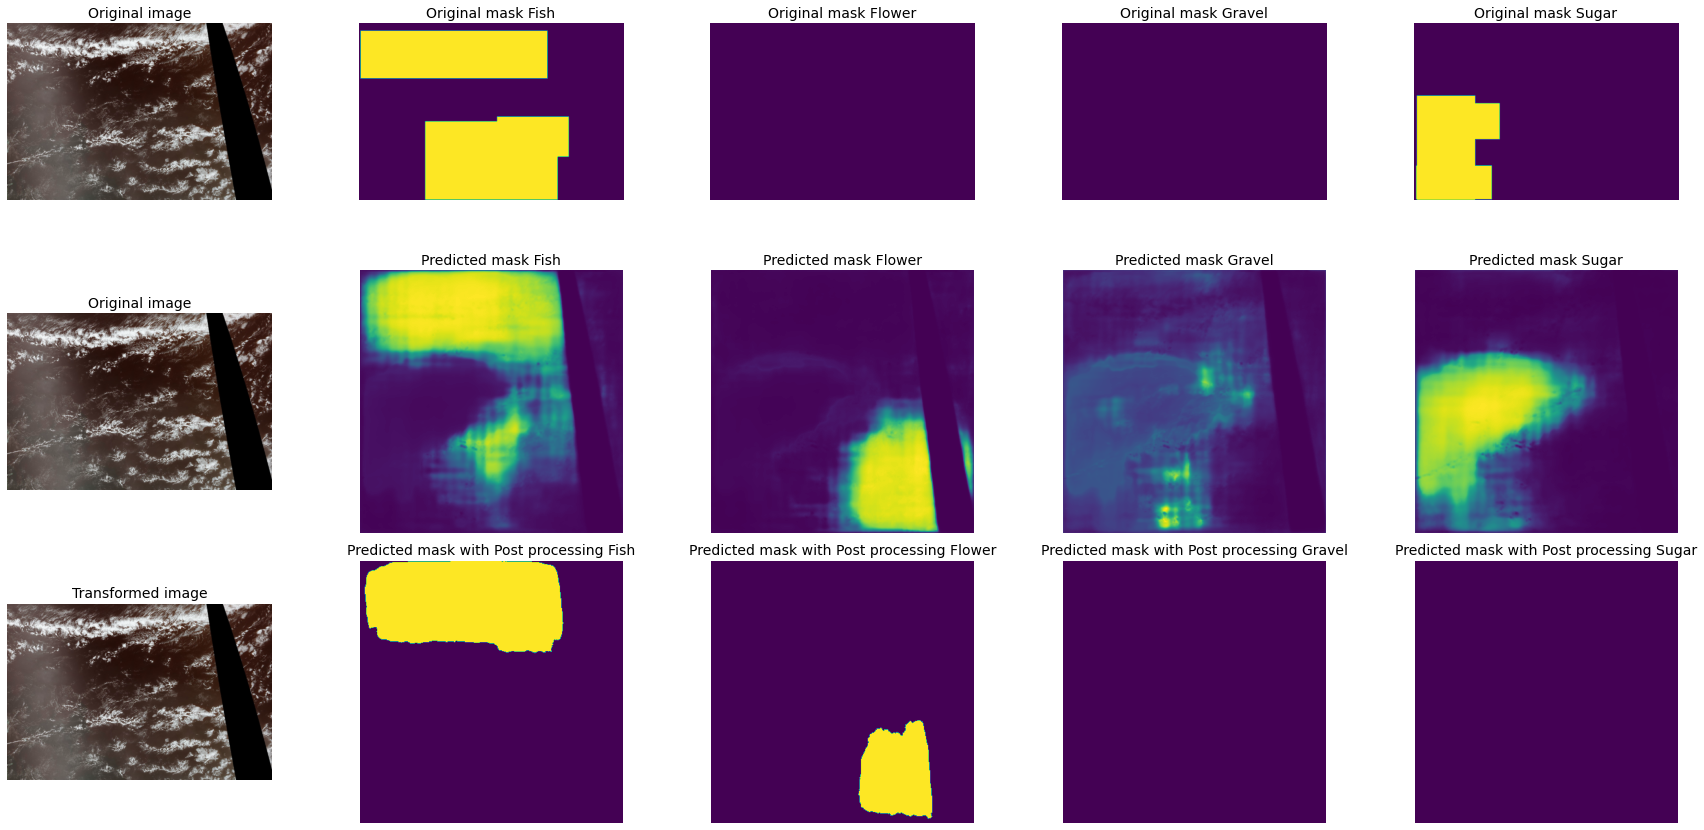

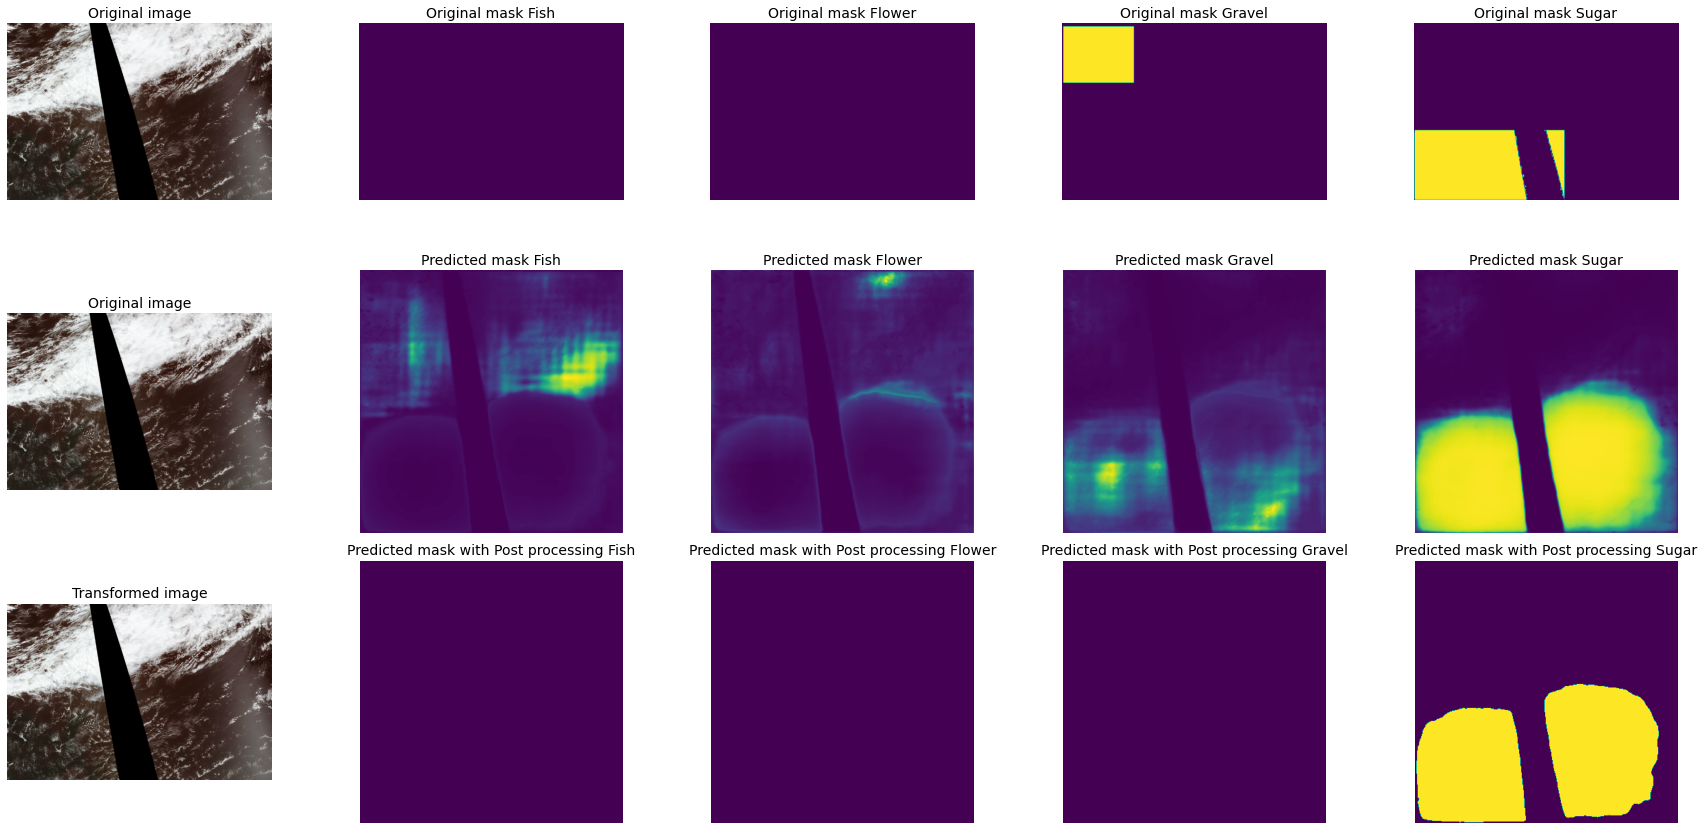

In [ ]:
# choose 3 samples from validation set
images_to_predict=np.random.choice(cv_data['image_id'].unique(), 3, replace=False)
print(images_to_predict)
# get the validation data for them
masks_to_visualize=cv_data[cv_data['image_id'].isin(images_to_predict)].copy()
# get predictions
#preds=model.predict_generator(valid_batches,verbose=1)

print(masks_to_visualize.shape)

vis_pred_gen=Val_DataGenerator(masks_to_visualize, shuffle=False, batch_size=len(masks_to_visualize))
vis_preds=model.predict_generator(vis_pred_gen)
print(vis_preds.shape)

for i in range(masks_to_visualize.shape[0]):
    masks=np.zeros((1400, 2100, 4))
    predicted_mask=np.zeros((IMG_HEIGHT, IMG_WIDTH, 4))
    post_processed_mask=np.zeros((IMG_HEIGHT, IMG_WIDTH, 4))
    image_name=masks_to_visualize['image_id'].iloc[i]
    image_data=cv2.imread(train_base_path + image_name)
    for j in range(4):
        orig_mask = conv_rle_to_mask(masks_to_visualize[get_cloud_type(j+1)].iloc[i])
        predicted_mask[:,:,j] = vis_preds[i,:,:,j]
        pp_mask=post_process(predicted_mask[:,:,j], best_threshold[j], best_mask_size[j])
        masks[:,:,j]= orig_mask
        post_processed_mask[:,:,j] = pp_mask
    visualize_val_predictions(image_data, masks, predicted_mask, post_processed_mask)

## Visualize predictions for test dataset

In [ ]:
# get list of test image names. The CSV doesnt have RLE pixel info (ground truth). So validation is not possible.
test_data = pd.read_csv(f'{path}/sample_submission.csv')
display(test_data.head())
test_data['image'] = test_data['Image_Label'].apply(lambda x: x.split('_')[0])
display(test_data.head())

Image_Label EncodedPixels
0    002f507.jpg_Fish           1 1
1  002f507.jpg_Flower           1 1
2  002f507.jpg_Gravel           1 1
3   002f507.jpg_Sugar           1 1
4    0035ae9.jpg_Fish           1 1

Image_Label EncodedPixels        image
0    002f507.jpg_Fish           1 1  002f507.jpg
1  002f507.jpg_Flower           1 1  002f507.jpg
2  002f507.jpg_Gravel           1 1  002f507.jpg
3   002f507.jpg_Sugar           1 1  002f507.jpg
4    0035ae9.jpg_Fish           1 1  0035ae9.jpg

In [ ]:
# Data generator for the test data
class Test_DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 32,shuffle=False, 
                 preprocess=None, path=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.directory = path
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':False, 'samplewise_std_normalization' : True}
        
        X = np.empty((self.batch_size,IMG_HEIGHT,IMG_WIDTH,3),dtype=np.float32) #images
        y = np.empty((self.batch_size,IMG_HEIGHT,IMG_WIDTH,4),dtype=np.float32)    #masks
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['image'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = image.load_img(self.directory + f).resize((IMG_WIDTH,IMG_HEIGHT))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y

In [ ]:
def visualize_test_predictions(image, predicted_mask, post_process_mask):
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}

    f, ax = plt.subplots(2, 5, figsize=(24, 12))


    ax[0, 0].imshow(image)
    ax[0, 0].set_title("Original image", fontsize=fontsize)
    ax[0, 0].axis('off')

    for i in range(4):
        ax[0, i + 1].imshow(predicted_mask[:, :, i])
        ax[0, i + 1].set_title(f"Predicted mask {class_dict[i]}", fontsize=fontsize)
        ax[0, i + 1].axis('off')

    ax[1, 0].imshow(image)
    ax[1, 0].set_title("Transformed image", fontsize=fontsize)
    ax[1, 0].axis('off')

    for i in range(4):
        ax[1, i + 1].imshow(post_process_mask[:, :, i])
        ax[1, i + 1].set_title(
            f"Predicted mask with Post processing {class_dict[i]}", fontsize=fontsize
        )
        ax[1, i + 1].axis('off')
    plt.tight_layout()


['ab94b40.jpg_Flower' 'adbefb7.jpg_Gravel' '35f8718.jpg_Fish']
             Image_Label EncodedPixels        image
3240    35f8718.jpg_Fish           1 1  35f8718.jpg
9865  ab94b40.jpg_Flower           1 1  ab94b40.jpg
9962  adbefb7.jpg_Gravel           1 1  adbefb7.jpg


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(3, 384, 384, 4)


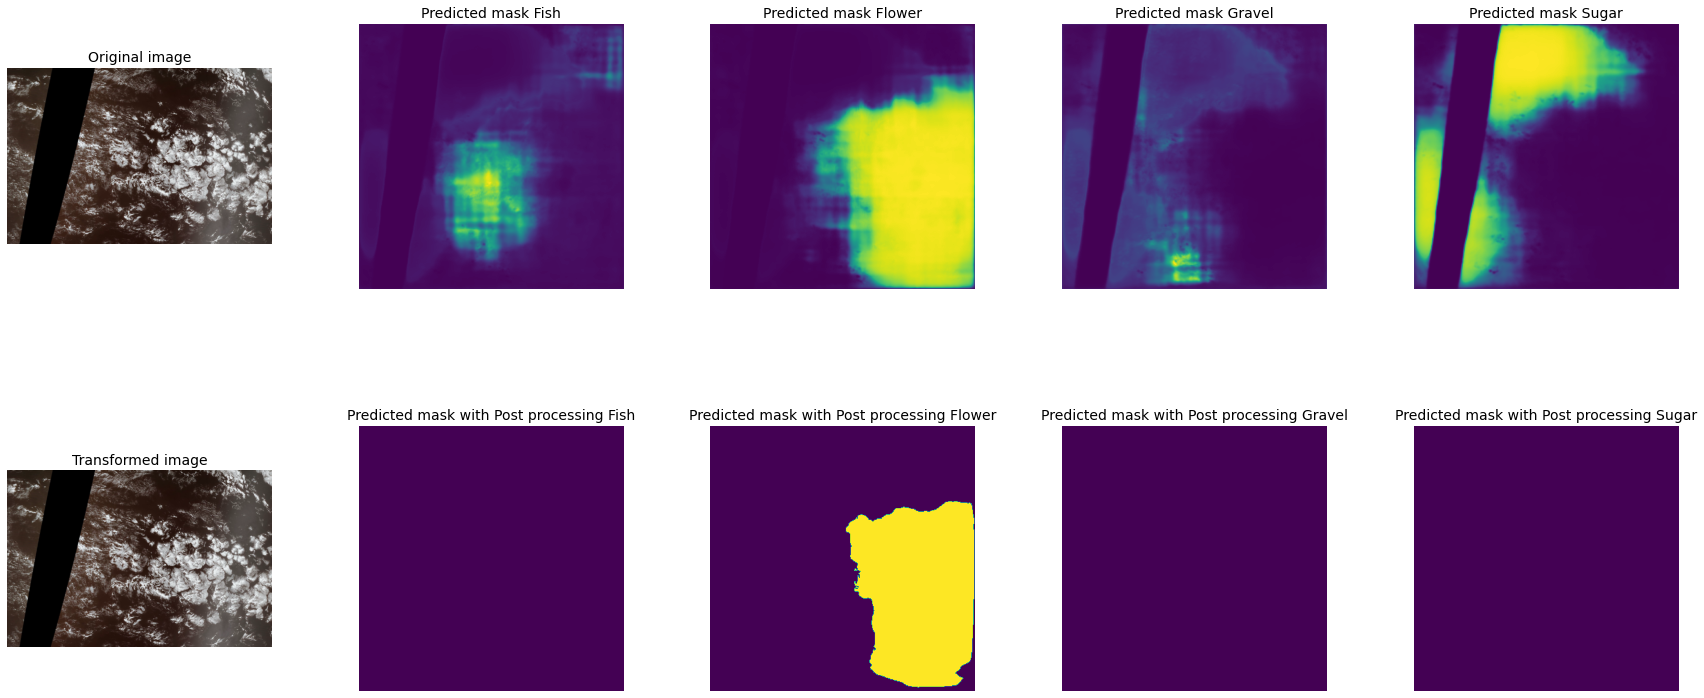

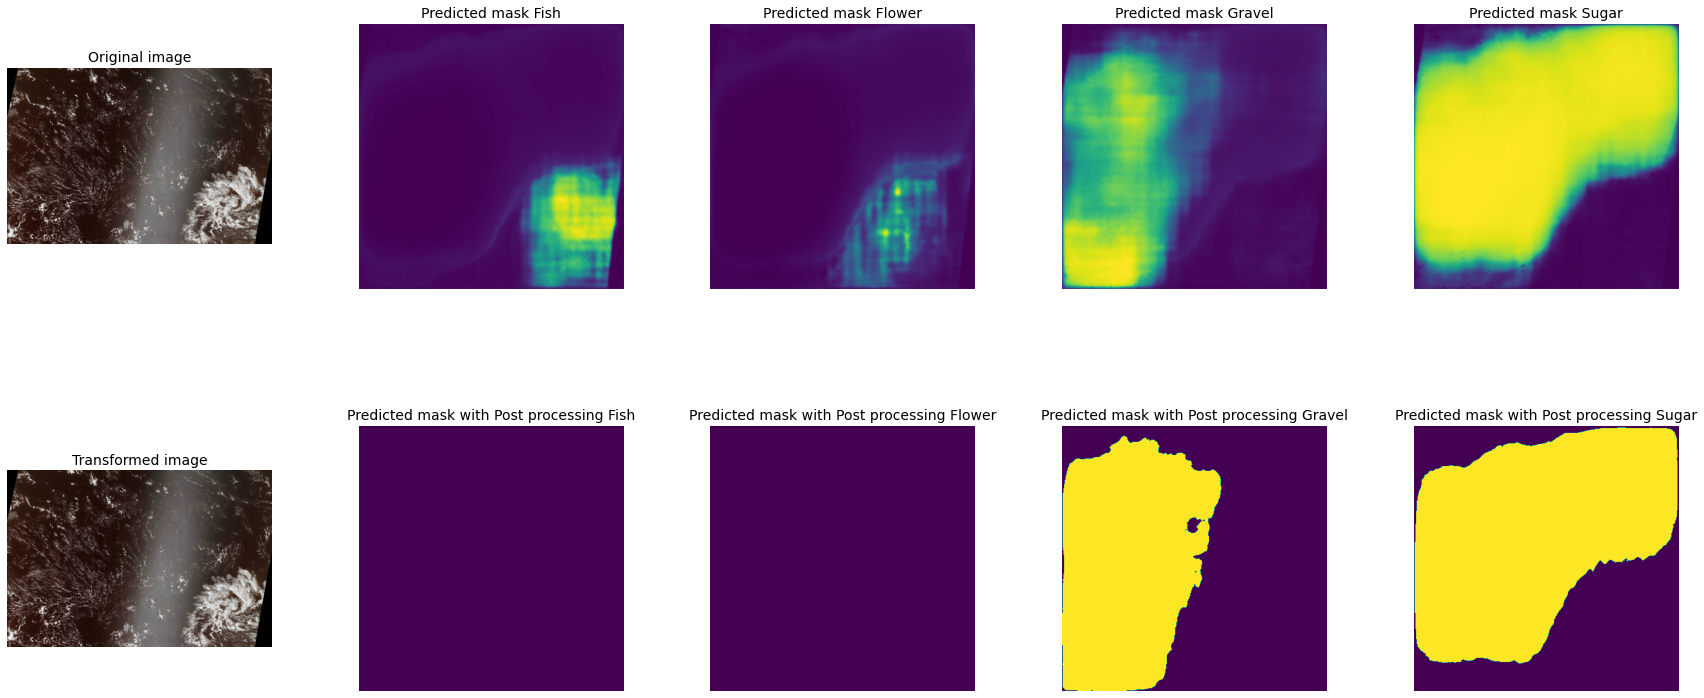

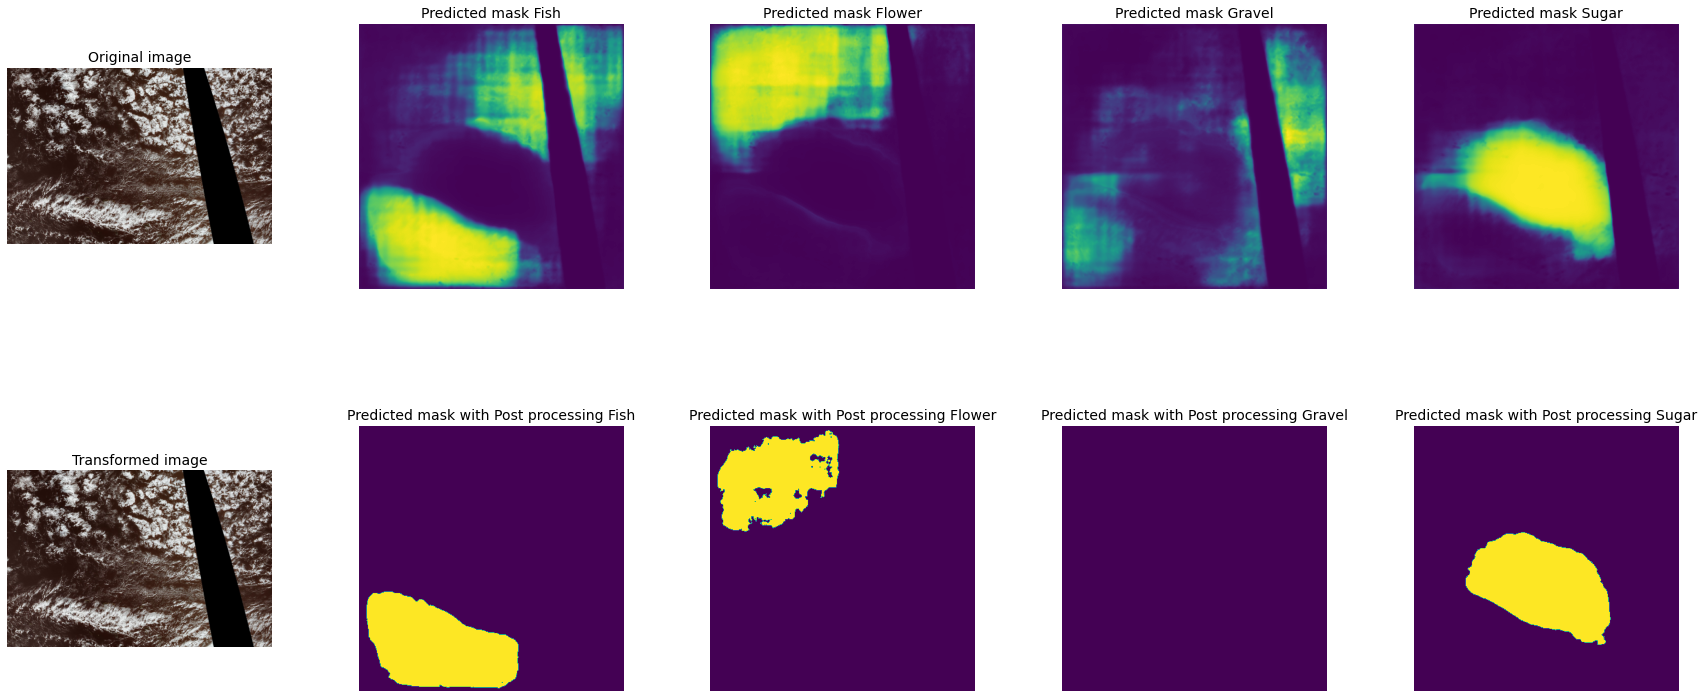

In [ ]:
test_base_path = '/content/drive/MyDrive/Colab_Notebooks/data/understanding_cloud_organization/test_images/'
# choose 3 test samples from test set
test_images_to_predict=np.random.choice(test_data['Image_Label'].unique(), 3, replace=False)
print(test_images_to_predict)
# get predictions
test_masks_to_visualize=test_data[test_data['Image_Label'].isin(test_images_to_predict)].copy()
print(test_masks_to_visualize)

test_pred_gen=Test_DataGenerator(test_masks_to_visualize, shuffle=False, batch_size=len(test_images_to_predict), path=test_base_path)
test_preds=model.predict_generator(test_pred_gen)
print(test_preds.shape)


for i in range(test_masks_to_visualize.shape[0]):
    masks=np.zeros((1400, 2100, 4))
    predicted_mask=np.zeros((IMG_HEIGHT, IMG_WIDTH, 4))
    post_processed_mask=np.zeros((IMG_HEIGHT, IMG_WIDTH, 4))
    image_name=test_masks_to_visualize['image'].iloc[i]
    image_data=cv2.imread(test_base_path + image_name)
    for j in range(4):
        orig_mask = conv_rle_to_mask(masks_to_visualize[get_cloud_type(j+1)].iloc[i])
        predicted_mask[:,:,j] = test_preds[i,:,:,j]
        pp_mask=post_process(predicted_mask[:,:,j], best_threshold[j], best_mask_size[j])
        post_processed_mask[:,:,j] = pp_mask
    visualize_test_predictions(image_data, predicted_mask, post_processed_mask)

## Comparison with Resnet Transfer Learning

In [ ]:
!pip install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
t_model = sm.Unet(
    'resnet34', 
    classes=4,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    activation='sigmoid'
)
t_model.compile(optimizer=Nadam(lr=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
t_model.summary()

     |████████████████████████████████| 51kB 5.3MB/s 
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
85524480/85521592 [==============================] - 4s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 384, 384, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 390, 390, 3)  0           bn_data[0][0]                    
_______________________________________________________________________________________________

In [ ]:
t_checkpoints = ModelCheckpoint(path + '/clouds_model_keras_transfer.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
t_callbacks_list = [t_checkpoints]

In [ ]:
t_history = t_model.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose=1,
                              callbacks = t_callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
147/147 [==============================] - 594s 4s/step - loss: 1.2435 - dice_coef: 0.2857 - val_loss: 1.2375 - val_dice_coef: 0.3690

Epoch 00001: val_dice_coef improved from -inf to 0.36904, saving model to /content/drive/MyDrive/Colab_Notebooks/data/understanding_cloud_organization/clouds_model_keras_transfer.h5
Epoch 2/30
147/147 [==============================] - 586s 4s/step - loss: 0.9493 - dice_coef: 0.4008 - val_loss: 1.0153 - val_dice_coef: 0.4609

Epoch 00002: val_dice_coef improved from 0.36904 to 0.46094, saving model to /content/drive/MyDrive/Colab_Notebooks/data/understanding_cloud_organization/clouds_model_keras_transfer.h5
Epoch 3/30
147/147 [==============================] - 575s 4s/step - loss: 0.8787 - dice_coef: 0.4528 - val_loss: 0.7958 - val_dice_coef: 0.5227

Epoch 00003: val_dice_coef improved from 0.46094 to 0.52269, saving model to /content/drive/MyDrive/Colab_Notebooks/data/understanding_cloud_organization/clouds_model_keras_transfer.h5
Epoch 4/30

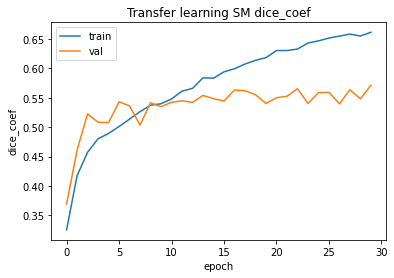

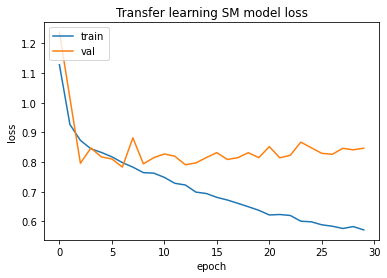

In [ ]:
# summarize history for dice_coef
plt.plot(t_history.history['dice_coef'])
plt.plot(t_history.history['val_dice_coef'])
plt.title('Transfer learning SM dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(t_history.history['loss'])
plt.plot(t_history.history['val_loss'])
plt.title('Transfer learning SM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()